# Multi-Actor Fish Game

This notebook will demonstrate the use of Rhodium to examine multiple formulations of the two harvester Fish Game.

In [1]:
import numpy as np
import itertools
from rhodium import * 
from Harvesting_formulations.two_coop import hrvSTR # note need to think about best way to incorporate this into a notebook
import json

# plotting options
%matplotlib inline
sns.set()
sns.set_style('darkgrid')

/home/dfg42/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Defining the Model

(From Dave Hadka's original): The model can be any Python function, with any number of input arguments. The names of the input arguments will become important later. The model can also return any number of outputs.

In this formulation we'll examine a fisheries system with two species a preditor and a prey, and two harvesters, one that harvests the preditor and one that harvests the prey.

In [2]:
N = 100 # Number of realizations of environmental stochasticity

tSteps = 100 # no. of timesteps to run the fish game on

# Define problem to be solved
def fish_game(vars, # contains all C, R, W for RBF policy
              a = 0.005, # rate at which the prey is available to the predator
              b = 0.5, # prey growth rate
              c = 0.5, # rate with which consumed prey is converted to predator abundance
              d = 0.1, # predator death rate
              h = 0.1, # handling time (time each predator needs to consume the caught prey)
              K = 2000, # prey carrying capacity given its environmental conditions
              m = 0.7, # predator interference parameter
              sigmaX = 0.004, # variance of stochastic noise in prey population
              sigmaY = 0.004): # variance of stochastic noise of predator population
    x = np.zeros(tSteps+1) # Create prey population array
    y = np.zeros(tSteps+1) # Create predator population array
    z_a = vars[:101] # Create harvest array
    z_b = vars[101:]

    # Create array to store harvest for all realizations
    harvest_a = np.zeros([N,tSteps+1])
    harvest_b = np.zeros([N,tSteps+1])
    # Create array to store prey for all realizations
    prey = np.zeros([N,tSteps+1])
    # Create array to store predator for all realizations
    predator = np.zeros([N,tSteps+1])
    
    # Create array to store metrics per realization
    NPV_a = np.zeros(N)
    NPV_b = np.zeros(N)
    cons_low_harv = np.zeros(N)
    harv_1st_pc = np.zeros(N)    
    
    # Create array with environmental stochasticity for prey
    epsilon_prey = np.random.normal(0.0, sigmaX, N)
    
    # Create array with environmental stochasticity for predator
    epsilon_predator = np.random.normal(0.0, sigmaY, N)

    # Go through N possible realizations
    for i in range(N):
        # Initialize populations and values
        x[0] = prey[i,0] = K
        y[0] = predator[i,0] = 250
        NPVharvest_a = harvest_a[i,0] = z_a[0]*x[0]   
        NPVharvest_b = harvest_b[i,0] = z_b[0]*y[0] 
        # Go through all timesteps for prey, predator, and harvest
        for t in range(tSteps):
            if x[t] > 0 and y[t] > 0:
                x[t+1] = (x[t] + b*x[t]*(1-x[t]/K) - (a*x[t]*y[t])/(np.power(y[t],m)+a*h*x[t]) - z_a[t]*x[t])* np.exp(epsilon_prey[i]) # Prey growth equation
                y[t+1] = (y[t] + c*a*x[t]*y[t]/(np.power(y[t],m)+a*h*x[t]) - d*y[t] - z_b[t]*y[t]) *np.exp(epsilon_predator[i]) # Predator growth equation
            prey[i,t+1] = x[t+1]
            predator[i,t+1] = y[t+1]
            harvest_a[i,t+1] = z_a[t+1]*x[t+1]
            harvest_b[i,t+1] = z_b[t+1]*y[t+1]
            NPVharvest_a = NPVharvest_a + harvest_a[i,t+1]*(1+0.05)**(-(t+1))
            NPVharvest_b = NPVharvest_b + harvest_b[i,t+1]*(1+0.05)**(-(t+1))
        NPV_a[i] = NPVharvest_a
        NPV_b[i] = NPVharvest_b
        low_hrv = [harvest_a[i,j]<prey[i,j]/20 for j in range(len(harvest_a[i,:]))] # Returns a list of True values when there's harvest below 5%
        count = [ sum( 1 for _ in group ) for key, group in itertools.groupby( low_hrv ) if key ] # Counts groups of True values in a row
        if count: # Checks if theres at least one count (if not, np.max won't work on empty list)
            cons_low_harv[i] = np.max(count)  # Finds the largest number of consecutive low harvests
        else:
            cons_low_harv[i] = 0
        harv_1st_pc[i] = np.percentile(harvest_a[i,:],1)
    
    return (np.mean(NPV_a), # Mean NPV for all realizations
            np.mean(NPV_b), # Mean NPV for all realizations
            np.mean((K-prey)/K), # Mean prey deficit
            #np.mean(cons_low_harv), # Mean worst case of consecutive low harvest across realizations
            #np.mean(harv_1st_pc), # 5th percentile of all harvests
            np.mean((250-predator)/250))#(predator < 1).sum(axis=1))) 

Next, we define a Rhodium model. A Rhodium model provides additional annotations for the function above. In particular, we will identify all parameters (inputs) and responses (outputs) of interest.

In [3]:
model = Model(fish_game)

model.parameters = [Parameter("vars"),
                    Parameter("a"),
                    Parameter("b"),
                    Parameter("c"),
                    Parameter("d"),
                    Parameter("h"),
                    Parameter("K"),
                    Parameter("m"),
                    Parameter("sigmaX"),
                    Parameter("sigmaY")]

model.responses = [Response("NPV_a", Response.MAXIMIZE),
                   Response("NPV_b", Response.MAXIMIZE),
                   Response("PreyDeficit", Response.MINIMIZE),
                   Response("PredatorExtinction", Response.MINIMIZE)] # check preditor extinction

Add decision variables (levers)

In [4]:
model.levers = [RealLever("vars", 0.0, 1.0, length = 202)]

In [6]:
if __name__ == "__main__":
    # Use a Process Pool evaluator, which will work on Python 3+
    with ProcessPoolEvaluator(4) as evaluator:
        RhodiumConfig.default_evaluator = evaluator
        output = optimize(model, "NSGAII", 10000)

here


/DATA/Dropbox/PhD/Research/Rhodium_Paper/Rhodium/rhodium/plot.py:859: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
  cb.set_clim(class_min, class_max)


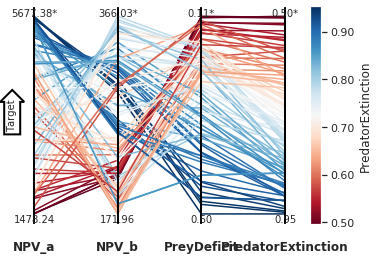

In [7]:
fig = parallel_coordinates(model, output, colormap="RdBu", target="top")

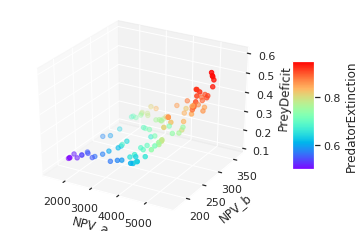

In [8]:
fig = scatter3d(model, output, c='PredatorExtinction')

(0, 425)

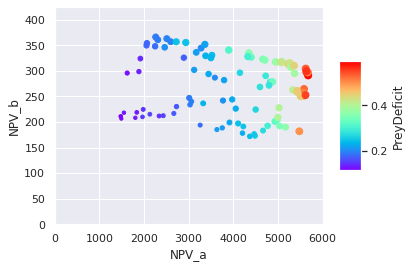

In [57]:
fig = scatter2d(model, output, c='PreyDeficit')
plt.xlim([0, 6000])
plt.ylim([0,425])

(0, 425)

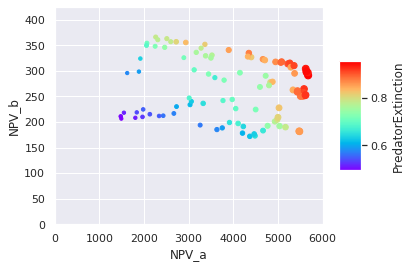

In [56]:
fig = scatter2d(model, output, c='PredatorExtinction')
plt.xlim([0, 6000])
plt.ylim([0,425])

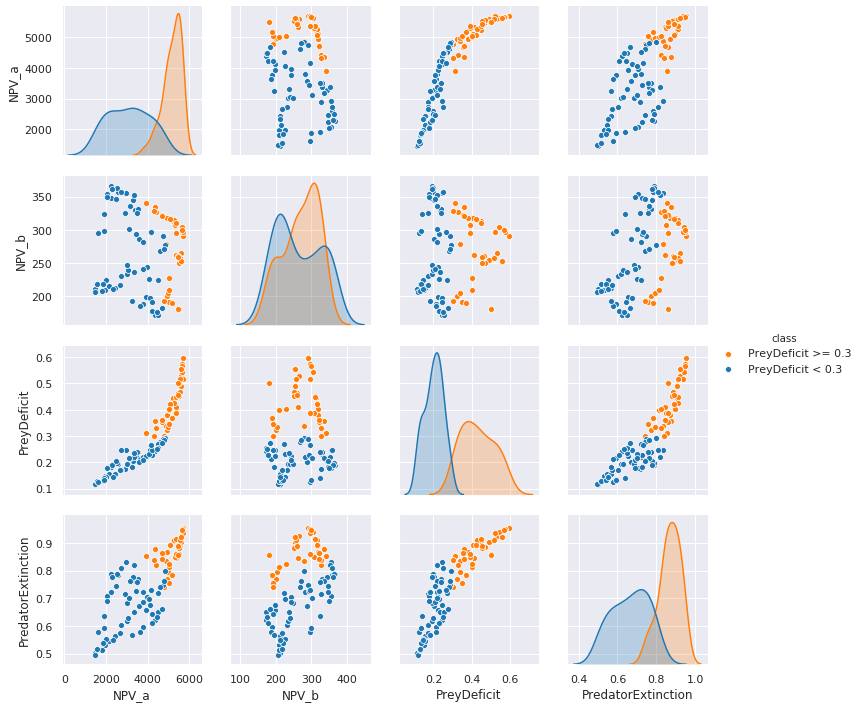

In [11]:
fig = pairs(model, output, brush=[Brush("PreyDeficit < 0.3"), Brush("PreyDeficit >= 0.3")])

Note: Seem to be losing the seaborn formatting in Pairwise above

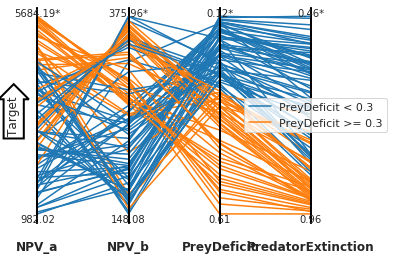

In [70]:
fig = parallel_coordinates(model, output, target="top", brush=[Brush("PreyDeficit < 0.3"), Brush("PreyDeficit >= 0.3")])

In [5]:
model.uncertainties = [UniformUncertainty("a", 0.002, 2),
                       UniformUncertainty("b", 0.005, 1),
                       UniformUncertainty("c", 0.2, 1),
                       UniformUncertainty("d", 0.05, 0.2),
                       UniformUncertainty("h", 0.001, 1),
                       UniformUncertainty("K", 100, 5000),
                       UniformUncertainty("m", 0.1, 1.5),
                       UniformUncertainty("sigmaX", 0.001, 0.01),
                       UniformUncertainty("sigmay", 0.001, 0.01)]

In [13]:
SOWs = sample_lhs(model, 1000)

In [1]:
print(np.size(output))

NameError: name 'np' is not defined

In [63]:
criteria = lambda x : x["PreyDeficit"] < 0.5 and x["PredatorExtinction"] < 0.5

n_policies = len(output)

if __name__ == "__main__":
    # Use a Process Pool evaluator, which will work on Python 3+
    with ProcessPoolEvaluator(4) as evaluator:
        RhodiumConfig.default_evaluator = evaluator
        reevaluation = [evaluate(model, update(SOWs, policy)) for policy in output]

#next make robustness metrics, borrow from post, quantify robustness of all solutions
#robustness_metrics = DataSet()
#robustness_metrics["satisficing"] = [satisficing_type1(model, reevaluation[i], criteria) for i in range(n_policies)]

SyntaxError: invalid syntax (<ipython-input-63-ab5de4394c80>, line 1)

In [6]:
reevaluation_file = open('intertemporal_reevaluation.txt')
reevaluation_str = reevaluation_file.read()
reevaluation_data = json.loads(reevaluation_str)

In [7]:
reevaluation = reevaluation_data

In [8]:
def satisficing_type1(model, results, expr=None):
    # if no criteria are defined, check the feasibility across SOWs
    if expr is None:
        return mean(check_feasibility(model, results))
    # otherwise, return the number of SOWs that meet the specified criteria
    else:
        satisfactory = [expr(result) for result in results]
        return sum(satisfactory)/len(results) 

In [14]:
criteria = lambda x : x["PreyDeficit"] < 0.5 and x["PredatorExtinction"] < 0.5 and x["NPV_a"] > 1000 and x["NPV_b"] > 200
robustness = np.zeros(len(reevaluation))
reevaluation_sols = []
for i, sol in enumerate(reevaluation):
    reevaluation_sols.append(DataSet(sol))
    robustness[i] = satisficing_type1(model, reevaluation_sols[i], expr=criteria)

In [15]:
print(robustness)

[0.015 0.116 0.119 0.116 0.116 0.114 0.039 0.029 0.081 0.095 0.018 0.027
 0.1   0.123 0.082 0.122 0.029 0.048 0.123 0.116 0.06  0.019 0.068 0.129
 0.124 0.09  0.121 0.123 0.086 0.123 0.045 0.104 0.121 0.125 0.071 0.12
 0.115 0.117 0.065 0.127 0.074 0.045 0.112 0.116 0.126 0.077 0.088 0.043
 0.113 0.105 0.113 0.048 0.12  0.024 0.121 0.117 0.043 0.121 0.123 0.1
 0.035 0.056 0.099 0.119 0.075 0.117 0.13  0.125 0.119 0.084 0.07  0.116
 0.128 0.117 0.119 0.085 0.109 0.114 0.124 0.116 0.105 0.113 0.05  0.121
 0.023 0.114 0.069 0.114 0.111 0.114 0.117 0.116 0.112 0.051 0.118 0.08
 0.042 0.13  0.103 0.118]


0.13


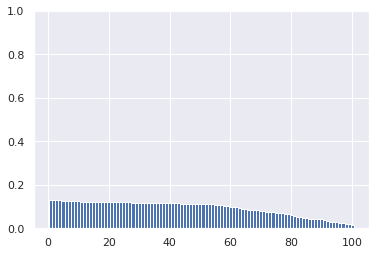

In [18]:
#from scipy.stats import rankdata
sorted_robustness = robustness[np.argsort(-robustness)]

#print(sorted_robustness)
%matplotlib inline
ranks = range(1, len(robustness)+1)
plt.bar(ranks, sorted_robustness, width=1)
plt.ylim([0,1])

print(robustness[97])

Select the most robust solution

In [19]:
most_robust = reevaluation_sols[97]
classification = most_robust.apply('"acceptable" if PreyDeficit < 0.5 and PredatorExtinction < 0.5 and NPV_a > 1000 and NPV_b > 200 else "unacceptable"')

How does it perform across objectives in the base SOW?

In [53]:
print([output[1][response.name] for response in model.responses])

[1479.4411066299147, 210.95184382592188, 0.11450009502990825, 0.4992532412808827]


In [41]:
%matplotlib qt
p = Prim(most_robust, classification, include=model.uncertainties.keys(), coi="acceptable")
box = p.find_box()
fig = box.show_tradeoff()

Factors m and b controll vulnerability: m > 1.07 b > 0.33

In [25]:
def regret_type1(model, results, baseline, percentile=90):
    quantiles = []
    
    for response in model.responses:
        if response.dir == Response.MINIMIZE or response.dir == Response.MAXIMIZE:
            values = [abs((result[response.name] - baseline[response.name]) / baseline[response.name]) for result in results]
            quantiles.append(np.percentile(values, percentile))
            
    return max(quantiles)

In [26]:
regret = np.zeros(len(reevaluation))
for i, sol in enumerate(reevaluation):
    regret[i] = regret_type1(model, reevaluation_sols[i], output[i])

NameError: name 'output' is not defined

Harvest over time of the most robust solution

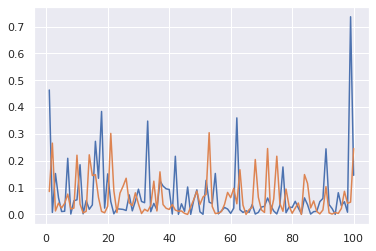

In [36]:
%matplotlib inline
plt.plot(range(1,101), reevaluation[97][0]['vars'][1:101])
plt.plot(range(1,101), reevaluation[97][0]['vars'][102:203])

Harvest over time of the least robust solution

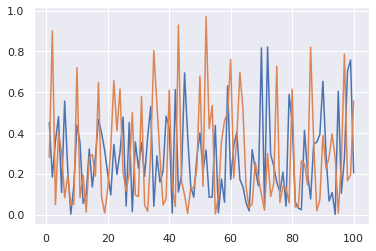

In [37]:
plt.plot(range(1,101), reevaluation[0][0]['vars'][1:101])
plt.plot(range(1,101), reevaluation[0][0]['vars'][102:203])